In [62]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures

# Part 1: training, creating and evaluating the best model

In [64]:

### Loading the training data
training_data = np.genfromtxt("training_data.csv", delimiter=',')
X = training_data[:,:-1]
y = training_data[:,-1]


def get_CV_RMSE(X, y, K_folds, model, H, apply_PCA=True):
    '''
    Returns a 2-tuple with:
    1) The CV-estimated RMSE given the data X and y, the number of K-folds, the model
    (e.g., "KNN Regression", "Kernel Regression", "Polynomial Regression", etc.), and the
    value of the hyperparameter H for each model (number of neighbors, bandwidth, degree, etc.)
    2) The standard error SE of the CV-estimated RMSE.
    '''
    X_temp = X
    
    # Standardizing features if model is Ridge or Lasso
    if model == "Ridge Regression" or model == "Lasso Regression":
        scaler = StandardScaler().fit(X_temp)
        X_temp = scaler.transform(X_temp)
    
    CVk = np.array([])
    kf = KFold(n_splits=K_folds, shuffle=True)
    
    for train_index, test_index in kf.split(X_temp):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Applying PCA (dimensionality reduction)
        if apply_PCA == True:
            scaler = StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            pca = PCA(n_components=5, svd_solver='full').fit(X_train)
            X_train = pca.transform(X_train)

            X_test = scaler.transform(X_test)
            X_test = pca.transform(X_test)

        # Fitting and predicting depending on the model
        if model == "Linear Regression":
            reg = LinearRegression()
            reg.fit(X_train, y_train)
            predictions = reg.predict(X_test)
        elif model == "Ridge Regression":
            reg = Ridge(alpha=H)
            reg.fit(X_train, y_train)
            predictions = reg.predict(X_test)
        elif model == "Lasso Regression":
            reg = Lasso(alpha=H, tol=1e-3)
            reg.fit(X_train, y_train)
            predictions = reg.predict(X_test)
        elif model == "KNN Regression":
            reg = KNeighborsRegressor(n_neighbors=H, weights="uniform")
            reg.fit(X_train, y_train)
            predictions = reg.predict(X_test)
        elif model == "Kernel Regression":
            reg = KernelReg(exog=X_train, endog=y_train, bw=[H]*X_train.shape[1],
                            var_type="c"*X_train.shape[1], ckertype="gaussian")
            predictions = reg.fit(X_test)[0]
        elif model == "Polynomial Regression":
            poly = PolynomialFeatures(degree=H)
            X_train_poly = poly.fit_transform(X_train)
            X_test_poly = poly.transform(X_test)

            # Adding trigonometric features only in Polynomial Regression
            X_train_sin = np.sin(X_train)
            X_train_cos = np.cos(X_train)
            X_test_sin = np.sin(X_test)
            X_test_cos = np.cos(X_test)
            X_train_poly = np.hstack([X_train_poly, X_train_sin, X_train_cos])
            X_test_poly = np.hstack([X_test_poly, X_test_sin, X_test_cos])
            
            reg = LinearRegression()
            reg.fit(X_train_poly, y_train)
            predictions = reg.predict(X_test_poly)
        RMSE = np.sqrt(np.mean((predictions - y_test)**2))
        CVk = np.append(RMSE, CVk)
    
    CV = np.mean(CVk)
    SE = np.std(CVk, ddof=1) / np.sqrt(len(CVk))

    return CV, SE

def get_optimals(RMSE_estimates, RMSE_stderrors, H_values, inv=False):
    '''
    Returns a 2-tuple with:
    1) The optimal (hyperparameter) value for each of the models under consideration. Corresponds to either
    the number of neighbors, the bandwidth, or the degree.
    2) The index of the optimal value. Useful to access the CV-estimated RMSE and its standard error of the
    optimal (hyperparameter) value.

    The 'inv' parameter, when True, gets the optimal (hyperparameter) value and its index assuming that,
    the higher the hyperparameter, the lesser the model complexity. Useful for Kernel & Polynomial Regressions.
    '''
    temp_estimates = RMSE_estimates.copy()
    temp_stderrors = RMSE_stderrors.copy()
    temp_H_values = list(H_values).copy()
    if inv == True:
        temp_estimates.reverse()
        temp_stderrors.reverse()
        temp_H_values.reverse()
    ordered_indices = np.argsort(temp_estimates)
    max_estimate_value = temp_estimates[ordered_indices[0]] + temp_stderrors[ordered_indices[0]]
    optimal_index = list(temp_estimates[:ordered_indices[0]+1] <= max_estimate_value).index(True)
    optimal_value = temp_H_values[optimal_index]
    return optimal_value, optimal_index

def get_optimals_iter(X, y, K_folds, model, H_values, iter, inv=False):
    '''
    Runs the get_optimals() function with the inputs provided iter times.
    
    Returns a 2-tuple with lists corresponding to 1) the optimal (hyperparameter) values
    and 2) the index of each corresponding optimal value.
    '''
    optimal_values = []
    optimal_index = []
    i = 1
    while i <= iter:
        RMSE = [get_CV_RMSE(X, y, K_folds, model, H) for H in H_values]
        RMSE_est, RMSE_stderror = map(list, zip(*RMSE))
        opt_val_temp, opt_index_temp = get_optimals(RMSE_est, RMSE_stderror, H_values, inv)
        optimal_values.append(opt_val_temp)
        optimal_index.append(opt_index_temp)
        i += 1
    return optimal_values, optimal_index

def get_CV_RMSE_iter(X, y, K_folds, model, H, iter, apply_PCA=True):
    '''
    Runs the get_CV_RMSE() function with the inputs provided iter times.
    
    Returns a list with the CV-estimated RMSE of each run. Helpful to go beyond a simple
    point estimate of the estimated prediction error of each model, and understand its variance.
    '''
    CVs = []
    i = 1
    while i <= iter:
        CVs.append(get_CV_RMSE(X, y, K_folds, model, H, apply_PCA)[0])
        i += 1
    return CVs

### Applying PCA to reduce multicollinearity (after centering & standardizing the data)
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
pca = PCA(n_components=5, svd_solver='full').fit(X)
X = pca.transform(X)

### Training the polynomial regression model with degree 4
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X)

### Adding the trigonometric features
X_sin = np.sin(X)
X_cos = np.cos(X)
X_poly = np.hstack([X_poly, X_sin, X_cos])

### Training the polynomial regression model with degree 4
reg_poly = LinearRegression().fit(X_poly, y)

def best_model(X_new):

    # Applying PCA (dimensionality reduction)
    X_new = scaler.transform(X_new)
    X_new = pca.transform(X_new)
    
    # Generating polynomial features with X_new
    X_new_poly = poly.transform(X_new)

    # Adding the trigonometric features
    X_new_sin = np.sin(X_new)
    X_new_cos = np.cos(X_new)
    X_new_poly = np.hstack([X_new_poly, X_new_sin, X_new_cos])

    # Predicting with Polynomial Regression
    predictions = reg_poly.predict(X_new_poly)
    
    return predictions

In [65]:
# Determining which test data will be used. If real test 
# data is available, it will be used. Otherwise, the 
# fake test data will be used.
if os.path.exists("test_data.csv"):
    test_data_filename = "test_data.csv"
elif os.path.exists("FAKE_test_data.csv"):
    test_data_filename = "FAKE_test_data.csv"
else:
    test_data_filename = None
    print("ERROR: Test data is missing!")
    
if test_data_filename:

    # loading the test data    
    test_data = np.genfromtxt(test_data_filename, delimiter=',')
    X_test = test_data[:,:-1]
    y_test = test_data[:,-1]

    # making predictions and computing the root mean squared error (RMSE)
    predictions = best_model(X_test)
    RMSE = np.sqrt(np.mean((predictions - y_test)**2))

    print("The RMSE is: ", RMSE)

The RMSE is:  9010694259.305075


# Part 2: analysis 

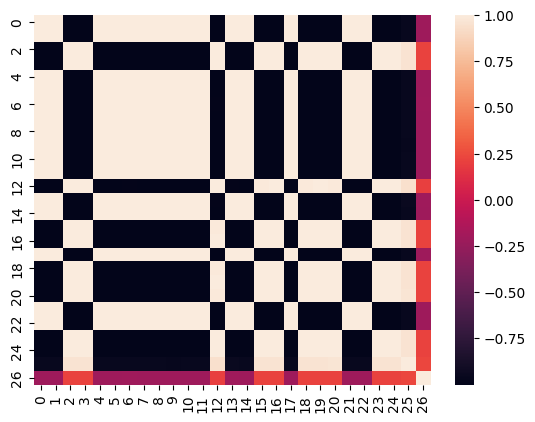

In [55]:
### Loading the training data
training_data = np.genfromtxt("training_data.csv", delimiter=',')
X = training_data[:,:-1]
y = training_data[:,-1]


### Correlation heatmap (we can see there is a really strong correlation between all features)
### Also known as multicollinearity in statistics
sns.heatmap(pd.DataFrame(training_data).corr());

In [56]:
df_temp = pd.DataFrame(training_data).corr().iloc[:26,:26]
pd.Series(np.absolute(df_temp.to_numpy().flatten())).sort_values(ascending=True)

337    0.941931
662    0.941931
363    0.950161
663    0.950161
597    0.954333
         ...   
540    1.000000
567    1.000000
594    1.000000
324    1.000000
675    1.000000
Length: 676, dtype: float64

0    0.995901
1    0.003114
2    0.000555
3    0.000233
4    0.000065
dtype: float64


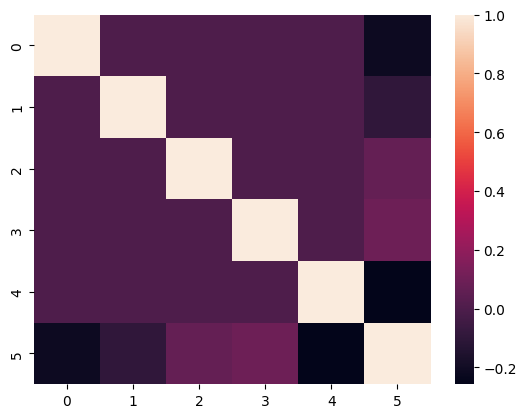

In [57]:
### Loading the training data again for reproducibility purposes in this cell
training_data = np.genfromtxt("training_data.csv", delimiter=',')
X = training_data[:,:-1]
y = training_data[:,-1]

### Applying PCA to reduce multicollinearity
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
pca = PCA(n_components=5, svd_solver='full').fit(X)
X = pca.transform(X)
training_data = np.hstack((X, y.reshape(-1,1)))
print(pd.Series(pca.explained_variance_ratio_))
sns.heatmap(pd.DataFrame(training_data).corr());

ModeResult(mode=10, count=3)

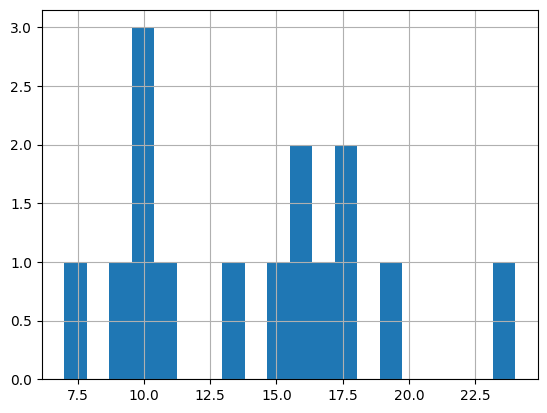

In [49]:
### WARNING: This code cell may take some minutes to run.
np.random.seed(42)
H_values = np.arange(1,100)
temp = get_optimals_iter(X, y, 10, "KNN Regression", H_values, iter=15, inv=True)[0]
pd.Series(temp).hist(bins=20)
stats.mode(temp)

### We se that K=10 seems like the best value for KNN Regression (10 neighbors)

ModeResult(mode=0.7, count=6)

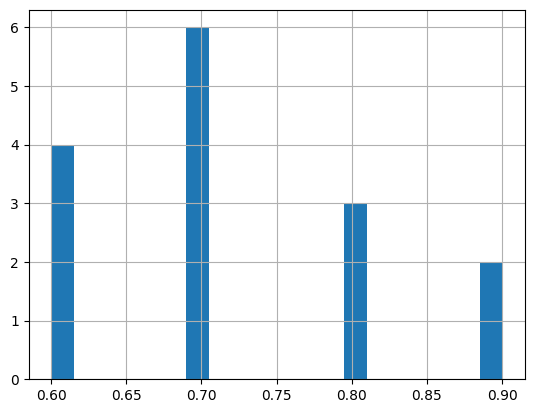

In [50]:
### WARNING: This code cell may take some minutes to run.
np.random.seed(42)
H_values = np.linspace(0.1,3,30)
temp = get_optimals_iter(X, y, 10, "Kernel Regression", H_values, iter=15, inv=True)[0]
pd.Series(temp).hist(bins=20)
stats.mode(temp)

### We se that bandwidth=0.1 seems like the best value for Kernel Regression

ModeResult(mode=4, count=24)

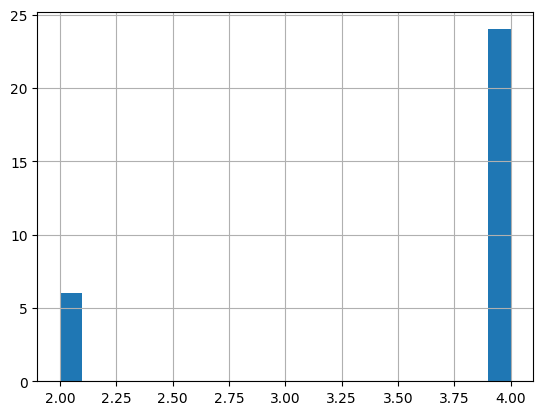

In [52]:
### WARNING: This code cell may take some minutes to run.
np.random.seed(42)
H_values = [1,2,3,4,5,6]
temp = get_optimals_iter(X, y, 10, "Polynomial Regression", H_values, iter=30, inv=False)[0]
pd.Series(temp).hist(bins=20)
stats.mode(temp)

### We see that degree=4 is clearly the best value for Polynomial Regression

ModeResult(mode=2.023786667526383, count=1)

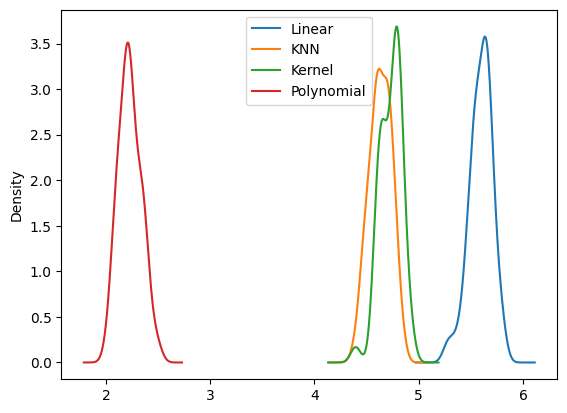

In [58]:
### Loading the training data again for reproducibility purposes in this cell
training_data = np.genfromtxt("training_data.csv", delimiter=',')
X = training_data[:,:-1]
y = training_data[:,-1]

### WARNING: This code cell may take some minutes to run.
np.random.seed(42)
CV_linear = get_CV_RMSE_iter(X, y, 10, "Linear Regression", H=None, iter=100, apply_PCA=True)
CV_knn = get_CV_RMSE_iter(X, y, 10, "KNN Regression", H=10, iter=100, apply_PCA=True)
CV_kernel = get_CV_RMSE_iter(X, y, 10, "Kernel Regression", H=0.7, iter=50, apply_PCA=True)
CV_poly = get_CV_RMSE_iter(X, y, 10, "Polynomial Regression", H=4, iter=50, apply_PCA=True)
pd.DataFrame(data=[CV_linear, CV_knn, CV_kernel, CV_poly],
             index=["Linear", "KNN", "Kernel", "Polynomial"]).T.plot.density()
stats.mode(CV_poly)

### Overall, we see that Polynomial Regression has the best CV estimated RMSE (estimated
### prediction error) among all the models and we decided to use this as our best model.

In [54]:
### Training each component of the best model 
reg_linear = LinearRegression().fit(X, y)
reg_knn = KNeighborsRegressor(n_neighbors=10, weights="uniform").fit(X, y)
reg_kernel = KernelReg(exog=X, endog=y, bw=[0.1]*X.shape[1], var_type="c"*X.shape[1], ckertype="gaussian")

poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X)
reg_poly = LinearRegression().fit(X_poly, y)

### Best Model with Granger-Ramanathan Averaging (GRA)
models = ["Linear", "KNN", "Kernel", "Poly"]
X_model_predictions = np.zeros((X.shape[0],len(models)))

for i, model in enumerate(models):
    if model == "Poly":
        poly = PolynomialFeatures(degree=4)
        X_poly = poly.fit_transform(X)
    for j in range(X.shape[0]):
        if model == "Linear":
            model_temp = LinearRegression().fit(np.delete(X, j, axis=0), np.delete(y, j))
            X_model_predictions[j, i] = model_temp.predict(X[j].reshape(1,X.shape[1]))[0]
            X_model_predictions[j, i] = model_temp.predict(X[j].reshape(1,X.shape[1]))[0]
        if model == "KNN":
            model_temp = KNeighborsRegressor(n_neighbors=10, weights="distance").fit(np.delete(X, j, axis=0), np.delete(y, j))
            X_model_predictions[j, i] = model_temp.predict(X[j].reshape(1,X.shape[1]))[0]
        if model == "Kernel":
            model_temp = KernelReg(exog=np.delete(X, j, axis=0), endog= np.delete(y, j), bw=[0.7]*X.shape[1], var_type="c"*X.shape[1], ckertype="gaussian")
            X_model_predictions[j, i] = model_temp.fit(X[j].reshape(1,X.shape[1]))[0][0]
        if model == "Poly":
            model_temp = LinearRegression().fit(np.delete(X_poly, j, axis=0), np.delete(y, j))
            X_model_predictions[j, i] = model_temp.predict(X_poly[j].reshape(1,X_poly.shape[1]))[0]

# Using Granger-Ramanathan Averaging (GRA) on X_model_predictions
weights = np.linalg.pinv(X_model_predictions).dot(y)
predictions = X_model_predictions @ weights
RMSE = np.sqrt(np.mean((predictions - y)**2))
print(RMSE)
pd.DataFrame(data=[predictions, y], index=["Forecast", "Actual"]).T

2.4483272780302174


,Forecast,Actual
0,-1.022708,-1.746287
1,3.264523,1.578410
2,-0.652935,0.201887
3,0.789459,0.175671
4,4.856776,1.710556
...,...,...
795,-0.094122,0.059570
796,2.150135,0.803492
797,0.064839,-0.002764
798,4.408540,3.904302
